In [436]:
import csv
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
from sklearn.linear_model import LinearRegression

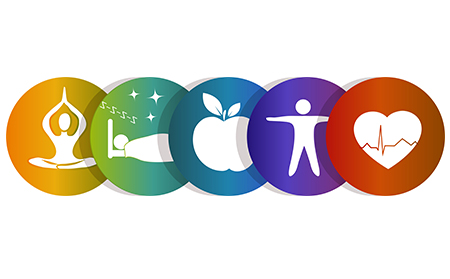

Health and well being, there are many different aspects that you need to focus on in order to keep yourself in good condition. Sometimes however, no matter how much you look after yourself, your body will breakdown in some way and you will need to go to the doctor. 

Living in the UK for most of my life I have been lucky enough to be able to take advantage of a completely free health care system. The NHS has probably saved my life on multiple occasions and I haven't had to pay a single penny. I have recently though, spent a couple of years abroad where for the first time in my life I had to think about health insurance and the idea of forking up cash to keep myself in good nick.

It certainly wasn't enjoyable by any means, however compared to the stories I've heard about how much people have to pay in the US, I payed peanuts! When I came accross this dataset of US insurance information I felt intruiged to find out just exactly how much someone could have to pay and what factors increase your cost?

So that's what I'm doing here, I'm going to try to create a model for US insurance costs that will accurately predict someones' bill depending on some basic details.

I will be using the below dataset.

In [437]:
df =  pd.read_csv('insurance.csv')
print(df)

      age     sex     bmi  children smoker     region      charges
0      19  female  27.900         0    yes  southwest  16884.92400
1      18    male  33.770         1     no  southeast   1725.55230
2      28    male  33.000         3     no  southeast   4449.46200
3      33    male  22.705         0     no  northwest  21984.47061
4      32    male  28.880         0     no  northwest   3866.85520
...   ...     ...     ...       ...    ...        ...          ...
1333   50    male  30.970         3     no  northwest  10600.54830
1334   18  female  31.920         0     no  northeast   2205.98080
1335   18  female  36.850         0     no  southeast   1629.83350
1336   21  female  25.800         0     no  southwest   2007.94500
1337   61  female  29.070         0    yes  northwest  29141.36030

[1338 rows x 7 columns]


First we'll need to do a little bit of wrangling. This data set is in superb condition, however all the numerical data is stored as strings. Which isn't ideal.

In [438]:
df.age = df.age.apply(int)
df.bmi = df.bmi.apply(float)
df.children = df.children.apply(int)
df.charges = df.charges.apply(float)

# I am also splitting the data in two here so that I can test my model on seperate data later.
# The data doesn't seem to be ordered in any way so this shouldn't create any bias between the sets.
model_df = df[df.index % 2 == 0].reset_index()
test_df = df[df.index % 2 != 0].reset_index()

So, what to do first? We can explore the data visually to see if we can identify patterns to turn into a model. Lets have a look at how some of the variables are correlated: 

In [439]:
model_df.corr()

,index,age,bmi,children,charges
index,1.000000,-0.036395,-0.020362,0.025637,0.023675
age,-0.036395,1.000000,0.137522,0.042730,0.316668
bmi,-0.020362,0.137522,1.000000,0.048655,0.182943
children,0.025637,0.042730,0.048655,1.000000,0.074576
charges,0.023675,0.316668,0.182943,0.074576,1.000000


Well, we see no strong linear relationships, but you can't tell much just by looking at these numbers. We can see that there is some correlation with age and charges, which you might expect. So lets start by looking at this relationship.

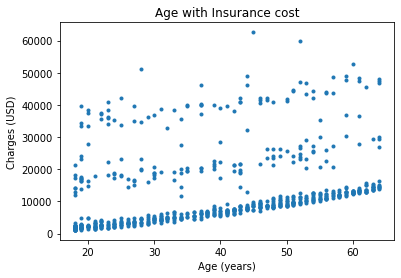

In [440]:
plt.plot(model_df.age, model_df.charges, '.')
plt.title('Age with Insurance cost')
plt.xlabel('Age (years)')
plt.ylabel('Charges (USD)')
plt.show()

Well... I've got to say that's not what I was expecting. We can certainly see a strong linear relationship but the data seems to be split into three separate lines. We do have some binary and categorical data in our data set which may explain it. What happens if we turn all the dots that are smokers red?

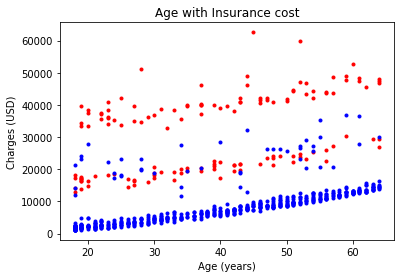

In [441]:
plt.plot(model_df.age[model_df.smoker == 'yes'], model_df.charges[model_df.smoker == 'yes'], 'r.')
plt.plot(model_df.age[model_df.smoker == 'no'], model_df.charges[model_df.smoker == 'no'], 'b.')
plt.title('Age with Insurance cost')
plt.xlabel('Age (years)')
plt.ylabel('Charges (USD)')
plt.show()

There are absolutely no smokers in that bottom line, in fact it would seem if you're a smoker, even in your late teens you'll be paying at least $12000! So yeah if your in the US...
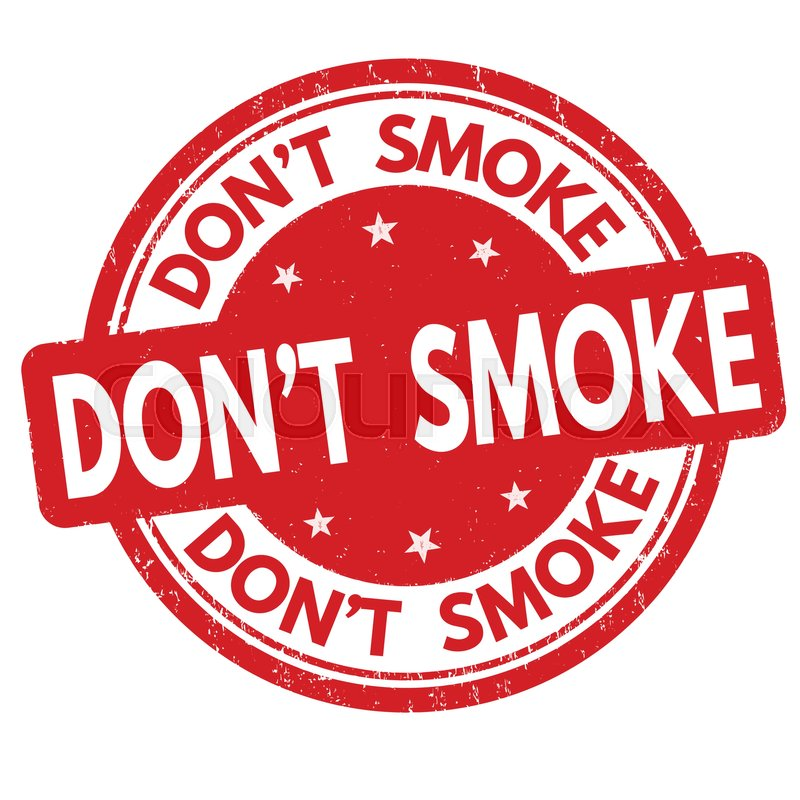
Not that I would recommend it if you're not in the US...
Anyway, lets get a better look at this by splitting the smokers and non smokers into seperate graphs:

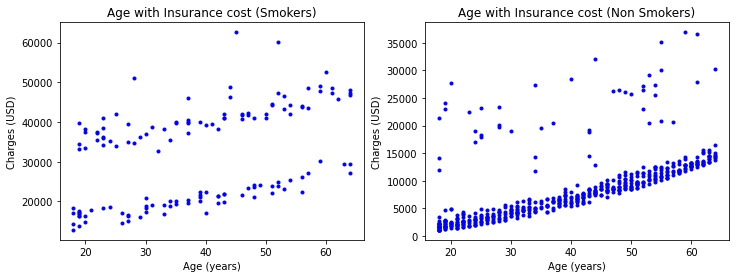

In [442]:
# Smoker plot
plt.figure(figsize = (12,4))
plt.subplot(1,2,1)
plt.plot(model_df.age[model_df.smoker == 'yes'], model_df.charges[model_df.smoker == 'yes'], 'b.')
plt.title('Age with Insurance cost (Smokers)')
plt.xlabel('Age (years)')
plt.ylabel('Charges (USD)')

# Non smoker plot
plt.subplot(1,2,2)
plt.plot(model_df.age[model_df.smoker == 'no'], model_df.charges[model_df.smoker == 'no'], 'b.')
plt.title('Age with Insurance cost (Non Smokers)')
plt.xlabel('Age (years)')
plt.ylabel('Charges (USD)')

plt.show()

We can see that smokers pay much more on average just by eyeballing the data. Both graphs however seem to be split into two groups. Perhaps both these splits can be explained by more categorical data? Well after a bit of exploring I came across this:

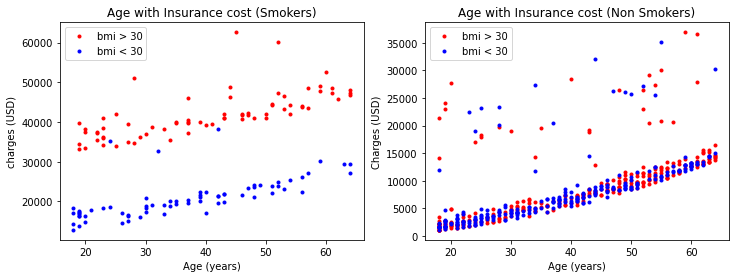

In [443]:
# Split the  model data into smoker and non smoker data
smoker_model = model_df[model_df.smoker == 'yes'].reset_index()
non_smoker_model = model_df[model_df.smoker == 'no'].reset_index()

# Plot smokers with bmi colour key
plt.figure(figsize = (12, 4))
plt.subplot(1,2,1)
plt.plot(smoker_model.age[smoker_model.bmi > 30], smoker_model.charges[smoker_model.bmi > 30], 'r.', label = 'bmi > 30')
plt.plot(smoker_model.age[smoker_model.bmi < 30], smoker_model.charges[smoker_model.bmi < 30], 'b.', label = 'bmi < 30')
plt.title('Age with Insurance cost (Smokers)')
plt.xlabel('Age (years)')
plt.ylabel('charges (USD)')
plt.legend()

# Plot non-smokers with bmi colour key
plt.subplot(1,2,2)
plt.plot(non_smoker_model.age[non_smoker_model.bmi > 30], non_smoker_model.charges[non_smoker_model.bmi > 30], 
         'r.', label = 'bmi > 30')
plt.plot(non_smoker_model.age[non_smoker_model.bmi < 30], non_smoker_model.charges[non_smoker_model.bmi < 30], 
         'b.', label = 'bmi < 30')
plt.title('Age with Insurance cost (Non Smokers)')
plt.xlabel('Age (years)')
plt.ylabel('Charges (USD)')
plt.legend()

plt.show()

It seems as if we have a clear dependance on bmi with insurance cost for smokers (with some outliers) but seemingly no correlation for non smokers! Not only that but the split in the smokers charges for bmi looks binary with a split at around 30 even though our bmi data is continuous!
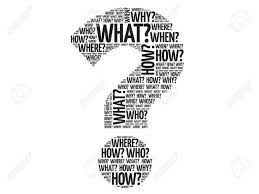
This would appear to indicate that if you are a smoker you will be charged higher rates once you reach a certain weight threshold whereas you won't be if you're a non smoker.

This doesn't make much intuitive sense to me. Is it being scewed some how? Do we have data on people with bmi in restricted bmi ranges? Lets have a look at the distribution:

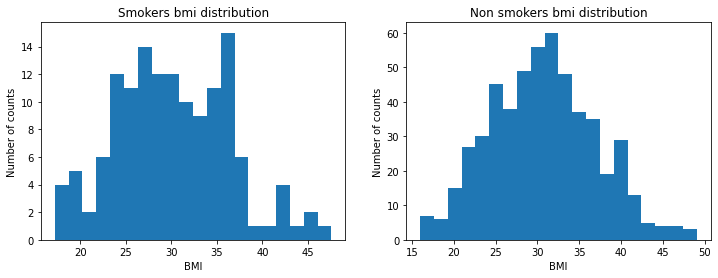

In [444]:
plt.figure(figsize = (12, 4))
plt.subplot(1,2,1)
plt.hist(smoker_model.bmi, bins = 20)
plt.title('Smokers bmi distribution')
plt.ylabel('Number of counts')
plt.xlabel('BMI')

plt.subplot(1,2,2)
plt.hist(non_smoker_model.bmi, bins = 20)
plt.title('Non smokers bmi distribution')
plt.ylabel('Number of counts')
plt.xlabel('BMI')

plt.show()

The distributions both look pretty normal and there is no indication of grouped bmi data. This means that smokers with a bmi of over 30 do indeed pay substantially more than those that don't. There is something speacial about a bmi of 30 however. It just so happens to be the threshold at which someone in the US is medically classified as obese. 

It would appear that in our model we can treat bmi's affect on smokers as binary, adding to their insurance cost once BMI is above 30.

You may be wondering about the data points above the main line in the non-smoker data. I'll tell you now that in all honesty, I couldn't find any relationship in the data given that intuitively explains what's happening here. My best guess however is that these are people with pre existing conditions. We don't have any data on that and I am pretty sure pre existing medical conditions can cause your insurance to increase quite a lot. 

It would seem though, that there are far fewer non-smokers outside of the main linear trend that we see in the graph, than are not. Lets make a box plot to see if we can classify these as statistical outliers.

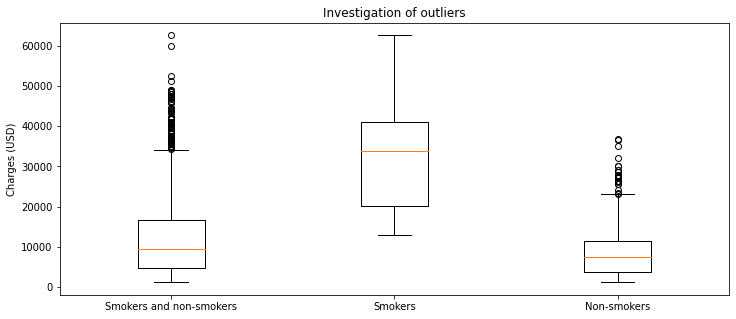

In [445]:
fig = plt.figure(figsize = (12, 5))
ax = fig.add_subplot(111)
ax.boxplot([model_df.charges, smoker_model.charges, non_smoker_model.charges])
ax.set_xticklabels(['Smokers and non-smokers', 'Smokers', 'Non-smokers'])
plt.title('Investigation of outliers')
plt.ylabel('Charges (USD)')
plt.show()

Statistically from the non-smokers boxplot above we can see that everything above ~ 23000 in charges in the non-smoker data is an outlier. Now we should be careful here. Just because data points are statistical outliers doesn't mean they neccessarily can be discarded. As I said before my guess is that these are people with pre-existing conditions. We don't have data on that, which could be the key to explaining these points. This data is also far from having a normal distribution so we should be wary of boxplots with such data.

If we look at the 'Smokers and non-smokers' box plot it is treating all data points above ~34,000 as statistical outliers. We know that a lot of these can be explained by bmi's affect on smokers. Discarding these outliers would be detrimental to our model if we want to include bmi. So I shall leave all data points in going forward but we shall explore the affect of removing these points a little bit towards the end.

What it does tell us however is that a majority of the datapoints so far not explained by our observations are statistical outliers, meaning there are only a small number of them and so shouldn't skew our model too much.

With this information I'd say the BMI, Smoker and Age data is enough to provide a good starting point for our model.

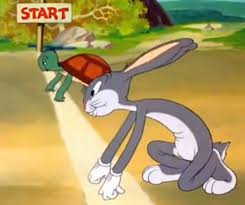

We're saying that someones insurance is calculated based on their age first, then if they are a smoker the cost increases and if they are a smoker and their bmi is greater than 30 it increases again. I've expressed this mathematically below:

$ \hat{Y} = \beta_{1}X_{age} + \beta_{2}X_{smoker} + \beta_{3}X_{smoker}X_{bmi} + \beta_{0}$

Where $\hat{Y}$ is the predicted insurance cost for a given age ($X_{age}$), smoker status ($X_{smoker}$) and binary bmi score ($X_{bmi}$). The coefficients $\beta_{1-3}$ are the weights of each element in the equation and $\beta_{0}$ is the intercept.

We'll first find $\beta_{2}$ and $\beta_{3}$. Performing linear regression on the smoker data for charges vs bmi should give us a coeficient equivalent to the average increase of charges for a smoker who has a BMI above 30.

We'll then perform linear regression on all of the data for charges vs smokers to give us a coefficient equilvalent to the average increase in charges for smokers. If they are a smoker with a BMI of above 30 however the bmi coefficient will be taken off before the regression to negate the impact of bmi. 

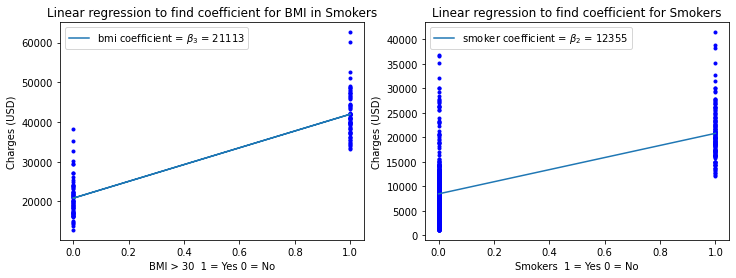

In [446]:
# First perform linear regression on our smoker data
bmi_fit = LinearRegression()
smoker_model['bmi_bin'] = smoker_model.bmi.apply(lambda x: 1 if x >= 30 else 0)
smoker_bmi_x = np.array(list(smoker_model.bmi_bin)).reshape(-1, 1)
smoker_bmi_y = np.array(list(smoker_model.charges)).reshape(-1, 1)
bmi_fit.fit(smoker_bmi_x, smoker_bmi_y)

# Now use that model to predict y values and extract our bmi coefficient
bmi_y_predicted = bmi_fit.predict(smoker_bmi_x)
bmi_coef = bmi_fit.coef_[0][0]

# Then take the bmi coefficient value from all relevant smoker data
model_df['charges_no_bmi'] = model_df.apply(lambda row: row['charges'] - bmi_coef 
                                            if((row['smoker'] == 'yes') & (row['bmi'] >= 30)) 
                                            else row['charges'], axis = 1)

# Perform linear regression on all data with respect to smokers
model_df['bmi_bin'] = model_df.bmi.apply(lambda x: 1 if x >= 30 else 0)
smoker_fit = LinearRegression()
model_df['smoker_bin'] = model_df.smoker.apply(lambda x: 1 if x == 'yes' else 0)
smoker_x = np.array(list(model_df.smoker_bin)).reshape(-1, 1)
smoker_y = np.array(list(model_df.charges_no_bmi)).reshape(-1, 1)
smoker_fit.fit(smoker_x, smoker_y)

# Extract smoker coefficient
smoker_coef = smoker_fit.coef_[0][0]

# Finally plot the regression models and data for visual representation
plt.figure(figsize = (12,4))
plt.subplot(1,2,1)
plt.plot(smoker_model.bmi_bin, smoker_model.charges,'b.')
plt.plot(smoker_bmi_x, bmi_y_predicted, label = r'bmi coefficient = $\beta_{3}$ = ' + str(round(bmi_coef)))
plt.title('Linear regression to find coefficient for BMI in Smokers')
plt.xlabel('BMI > 30  1 = Yes 0 = No')
plt.ylabel('Charges (USD)')
plt.legend()

plt.subplot(1,2,2)
smoker_y_predicted = smoker_fit.predict(smoker_x)
smoker_coef = smoker_fit.coef_[0][0]
plt.plot(model_df.smoker_bin, model_df.charges_no_bmi,'b.')
plt.plot(smoker_x, smoker_y_predicted, label = r'smoker coefficient = $\beta_{2}$ = ' + str(round(smoker_coef)))
plt.title('Linear regression to find coefficient for Smokers')
plt.xlabel('Smokers  1 = Yes 0 = No')
plt.ylabel('Charges (USD)')
plt.legend()

plt.show()

Alright, so we have our $\beta_{2}$ and $\beta_{3}$. We can now find $\beta_{1}$ using the same method with ages. This time of course we will have to account for the the affects of bmi and smoking, taking $\beta_{2}$ and $\beta_{3}$ off the charges where appropriate. We will take the intercept of our whole model ($\beta_{0}$) from the linear regression of the ages as that is the 'base' of our model.

The age coefficient is 267
The intercept is -2003


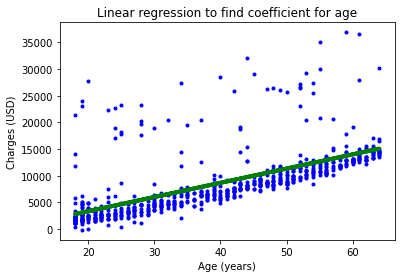

In [459]:
# First we create a new column with all charges corrected for bmi and smoker contributions
model_df['charges_no_smoking_or_bmi'] = model_df.apply(lambda row: row['charges_no_bmi'] - smoker_coef 
                                            if row['smoker'] == 'yes' 
                                            else row['charges_no_bmi'], axis = 1)

# Then create the model using linear regression
non_smoker_fitting_x = np.array(list(model_df.age)).reshape(-1, 1)
non_smoker_fitting_y = np.array(list(model_df.charges_no_smoking_or_bmi)).reshape(-1, 1)
age_line = LinearRegression()
age_line.fit(non_smoker_fitting_x, non_smoker_fitting_y)
age_charges_predicted = age_line.predict(non_smoker_fitting_x)

# Extract beta1 and beta0
age_coef = age_line.coef_[0][0]
intercept = age_line.intercept_[0]
print(r'The age coefficient is ' + str(round(age_coef)))
print(r'The intercept is ' + str(round(intercept)))

# Plot graph for visual representation
plt.figure(1)
plt.plot(model_df.age, model_df.charges_no_smoking_or_bmi,'b.')
plt.plot(non_smoker_fitting_x, age_charges_predicted, 'g', linewidth = 4)
plt.title('Linear regression to find coefficient for age')
plt.xlabel('Age (years)')
plt.ylabel('Charges (USD)')
plt.show()




That regression line seems a little high to the eye. The reason for this of course is because we have kept all of the outliers above the main chunk at the bottom (technical term) that we identiffied in the boxplots. We cannot explain why they differ so much from our model using the data available and so skew the line.

Again we shall continue with these outliers, they do skew the data but not drastically.

We now have all of our coefficients! It's time to put everything together and test the model.

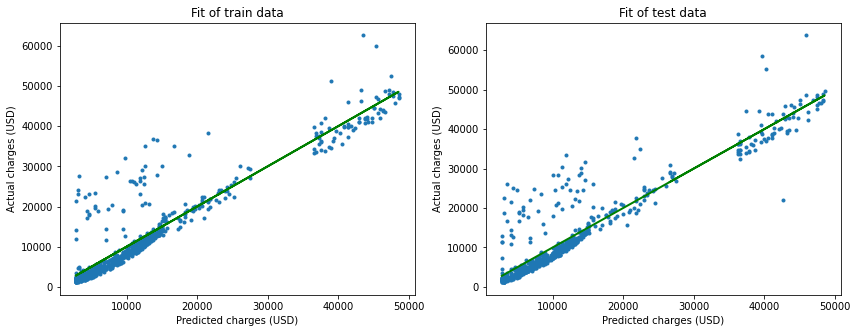

The percenage variation for our train data is 0.8530808070601003
The percenage variation for our test data is 0.8625217016659479


In [460]:
# Create model using equation and coefficients using train data
y_predicted_train = []
for i in range(len(model_df)):
    y_predicted_train.append(age_coef*model_df.age[i] + intercept + smoker_coef*model_df.smoker_bin[i] + 
                       bmi_coef*model_df.smoker_bin[i]*model_df.bmi_bin[i])
    
# Adjust the test data as we did for the train data    
test_df['smoker_bin'] = test_df.smoker.apply(lambda x: 1 if x == 'yes' else 0)
test_df['bmi_bin'] = test_df.bmi.apply(lambda x: 1 if x >= 30 else 0)


# Create model using equation and coefficients using test data
y_predicted_test = []
for i in range(len(test_df)):
    y_predicted_test.append(age_coef*test_df.age[i] + intercept + smoker_coef*test_df.smoker_bin[i] + 
                       bmi_coef*test_df.smoker_bin[i]*test_df.bmi_bin[i])

# Plot our predicted values againsts actual for both train and test data    
plt.figure(figsize = (14, 5))
plt.subplot(1,2,1)
plt.plot(y_predicted_train, model_df.charges, '.')
plt.plot(y_predicted_train, y_predicted_train, 'g', linewidth = 2)
plt.title('Fit of train data')
plt.xlabel('Predicted charges (USD)')
plt.ylabel('Actual charges (USD)')

plt.subplot(1,2,2)
plt.plot(y_predicted_test, test_df.charges, '.')
plt.plot(y_predicted_test, y_predicted_test, 'g', linewidth = 2)
plt.title('Fit of test data')
plt.xlabel('Predicted charges (USD)')
plt.ylabel('Actual charges (USD)')

plt.show()

# Calculate percentage variation for train data
R_squared = 1 - (((model_df.charges - y_predicted_train) ** 2).sum() / 
                 ((model_df.charges - model_df.charges.mean()) ** 2).sum())
print('The percenage variation for our train data is ' + str(R_squared))

# Calculate percentage variation for test data
R_squared = 1 - (((test_df.charges - y_predicted_test) ** 2).sum() /  
                 ((test_df.charges - test_df.charges.mean()) ** 2).sum())
print('The percenage variation for our test data is ' + str(R_squared))

Not bad! A percentage variation ($R^{2}$) value of 0.85 - 0.86 is great. The little variation in $R^{2}$ for the train and test set shows that we haven't overfitted with our model. Our model explains 85% of the variation in the data. 

Lets check against a standard multiple linear regression. Is our model actually any better than this algorithm?

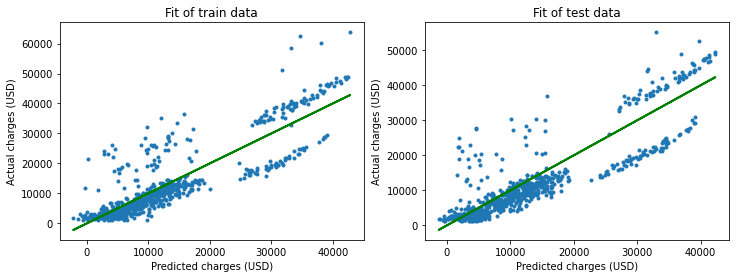

The percentage variance for the train data is 0.741440779137661
The percentage variance for the test data is 0.7482309163013758


In [449]:
from sklearn.model_selection import train_test_split

# Adjust data for the whole dataset
df['smoker_bin'] = df.smoker.apply(lambda x: 1 if x == 'yes' else 0)
df['bmi_bin'] = df.bmi.apply(lambda x: 1 if x >= 30 else 0)
x = df[['age', 'bmi', 'smoker_bin']]
y = df[['charges']]

# Split into train and test data
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size = 0.5, test_size = 0.5, random_state=6)

# Perform multiple linear regression
mlr = LinearRegression()
model=mlr.fit(x_train, y_train)
y_predict_train = mlr.predict(x_train)
y_predict_test = mlr.predict(x_test)

# Plot the predicted values againsts actual for both train and test data
plt.figure(figsize = (12, 4))
plt.subplot(1,2,1)
plt.plot(y_predict_train, y_train, '.')
plt.plot(y_predict_train, y_predict_train, 'g', linewidth = 2)
plt.title('Fit of train data')
plt.xlabel('Predicted charges (USD)')
plt.ylabel('Actual charges (USD)')

plt.subplot(1,2,2)
plt.plot(y_predict_test, y_test, '.')
plt.plot(y_predict_test, y_predict_test, 'g', linewidth = 2)
plt.title('Fit of test data')
plt.xlabel('Predicted charges (USD)')
plt.ylabel('Actual charges (USD)')

plt.show()

# Fetch R squared value for train and test
print('The percentage variance for the train data is ' + str(mlr.score(x_train, y_train)))
print('The percentage variance for the test data is ' + str(mlr.score(x_test, y_test)))

Well a score of 0.74 is good, but not quite as good as ours! We can see this visually as well, the graphs produced by multiple linear regression alone are clearly not as well fitted.

It is clear then that with just the age, bmi and smoker variables we can create a decent model. what about the other variables though? Will including them in our model make it even better, or just make our model overfitted? Lets find out.

Below I've made several colour coded plots with the different colours representing different numbers of children.

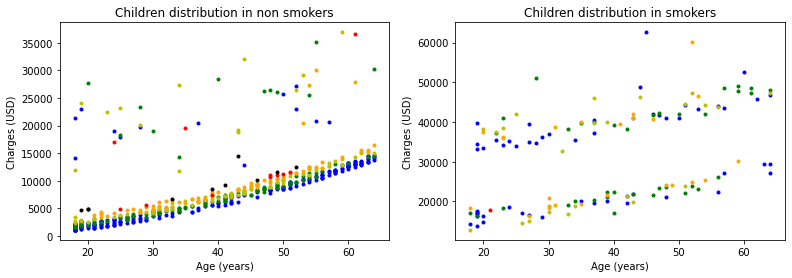

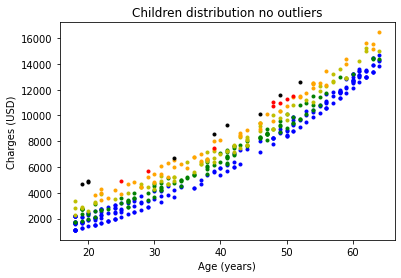

In [461]:
# Define function for colour coding
def plot_rainbow(data):
    plt.plot(data.age[data.children == 0], 
             data.charges[data.children == 0],'b.')
    plt.plot(data.age[data.children == 1], 
             data.charges[data.children == 1],'g.')
    plt.plot(data.age[data.children == 2], 
             data.charges[data.children == 2],'y.')
    plt.plot(data.age[data.children == 3], 
             data.charges[data.children == 3], '.', color = 'orange')
    plt.plot(data.age[data.children == 4], 
             data.charges[data.children == 4],'r.')
    plt.plot(data.age[data.children == 5], 
             data.charges[data.children == 5],'k.')

# Manual cutting of data to show quadratic relation (See below)    
non_smoker_no_outliers = non_smoker_model[((non_smoker_model.age < 45) & (non_smoker_model.charges < 11000)) | 
                                              ((non_smoker_model.age > 45) & (non_smoker_model.charges < 17000))]

# Plot out data 
plt.figure(1, figsize = (13, 4))

plt.subplot(1,2,1)
plot_rainbow(non_smoker_model)
plt.title('Children distribution in non smokers')
plt.xlabel('Age (years)')
plt.ylabel('Charges (USD)')

plt.subplot(1,2,2)
plot_rainbow(smoker_model)
plt.title('Children distribution in smokers')
plt.xlabel('Age (years)')
plt.ylabel('Charges (USD)')

plt.figure(2)
plot_rainbow(non_smoker_no_outliers)
plt.title('Children distribution no outliers')
plt.xlabel('Age (years)')
plt.ylabel('Charges (USD)')

plt.show()

Two things come to mind when looking at these graphs. One, that's a nice rainbow pattern right there meaning correlation, and two, that rainbow doesn't look as linear as it once did!

The rainbow pattern in the non smokers data seems to show that the more children you have the higher the insurance cost, this makes sence. It is also interesting to note that the amount of people with no children (blue dots) seem to increase once people leave middle age. This I assume can only mean that the number of children means the number of children that are currently under their care. Which is a significant distinction.

We can acount for this in our model again using linear regression. We will however have to include the rest of the data for consistency. The non smoker data does not seem to have the same linear relationship with children which will decrease the accuracy of the regression. This could be detrimantal as the more we include data that doesn't follow the trend in our regression we run the risk of overfitting. We'l keep it in for now though as that rainbow seems to good to leave out.

I've included the third graph in order to more clearlt point out the curve in the data. I've simply maunally cut out the data above the main line and plotted the rest. 

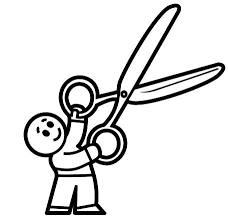

This curve can be accomodated by adjusting our model and adding quadratic components.

The new adjusted model can be mathematically expressed as below:

$ \hat{Y} = \beta_{1a}X_{age}^2 + \beta_{1b}X_{age} + \beta_{2}X_{smoker} + \beta_{3}X_{smoker}X_{bmi} + \beta_{4}X_{children} + \beta_{0}$

We can keep our previous $\beta_{2}$ and $\beta_{3}$ values but we will need to find our $\beta_{4}$ from another linear regression for charges vs children and $\beta_{0,1a,1b}$ from our quadratic terms in a new analysis with age.

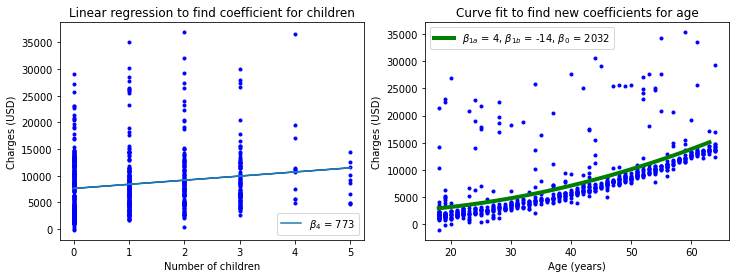

In [465]:
# Perform linear regression for the number of children
children_fit = LinearRegression()
children_x = np.array(list(model_df.children)).reshape(-1, 1)
children_y = np.array(list(model_df.charges_no_smoking_or_bmi)).reshape(-1, 1)
children_fit.fit(children_x, children_y)
children_y_predicted = children_fit.predict(children_x)

# Extract the coefficient beta4
children_coef = children_fit.coef_[0][0]

# Create updated charges column that accounts for the affects of children
def children_func(row):
    if row['children'] == 0:
        return row['charges_no_smoking_or_bmi']
    elif row['children'] == 1:
        return row['charges_no_smoking_or_bmi'] - children_coef 
    elif row['children'] == 2:
        return row['charges_no_smoking_or_bmi'] - children_coef*2
    elif row['children'] == 3:
        return row['charges_no_smoking_or_bmi'] - children_coef*3
    elif row['children'] == 4:
        return row['charges_no_smoking_or_bmi'] - children_coef*4
    elif row['children'] == 5:
        return row['charges_no_smoking_or_bmi'] - children_coef*5

model_df['charges_updated'] = model_df.apply(children_func, axis = 1)

# Perform a curve fit analysis to obtain the coefficients for age and y intercept
def objective(x, a, b, c):
	return a*x**2 + b*x + c

fit = curve_fit(objective, model_df.age, model_df.charges_updated)

# Extract the coefficients
abc, other = fit
age_coef1, age_coef2, intercept = abc

# Create plots to visualise the regressions
plt.figure(figsize = (12, 4))

plt.subplot(1,2,1)
plt.plot(model_df.children, model_df.charges_no_smoking_or_bmi,'b.')
plt.plot(children_x, children_y_predicted, label = r'$\beta_{4}$ = ' + str(round(children_coef)))
plt.title('Linear regression to find coefficient for children')
plt.xlabel('Number of children')
plt.ylabel('Charges (USD)')
plt.legend()
 
plt.subplot(1,2,2)
plt.plot(model_df.age, model_df.charges_updated,'b.')
x_line = np.arange(min(model_df.age), max(model_df.age), 1)
y_line = age_coef1*x_line**2 + age_coef2*x_line + intercept
plt.plot(x_line, y_line, 'g', linewidth=4, label = r'$\beta_{1a}$ = ' + str(round(age_coef1)) + 
         r', $\beta_{1b}$ = ' + str(round(age_coef2)) + 
         r', $\beta_{0}$ = ' + str(round(intercept)))
plt.title('Curve fit to find new coefficients for age')
plt.xlabel('Age (years)')
plt.ylabel('Charges (USD)')
plt.legend()

plt.show()

That linear increase with number of children is not very nice to look at. By that I mean the linear correlation seems very week. You may be wondering why I've kept this in for so long when I seem so scared that it will overfit the model. Well I'm of course cheating here as I have already done the analysis so I know it will work but pointing out the flaws is relevant. 

Before discussing this in more detail however, first lets look at how this model performs when add in the new coefficients.

3.5112527310445736


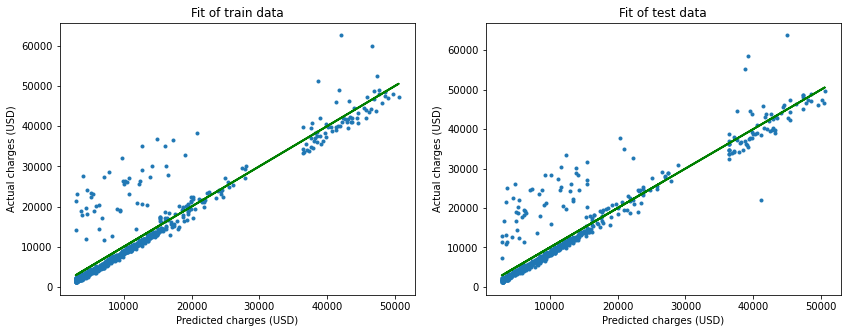

The percentage variation for our train data is 0.8596198923819375
The percentage variation for our test data is 0.8658155774124318


In [464]:
# Create model using equation and coefficients using train data
y_predicted_train = []
print(a)
for i in range(len(model_df)):
    y_predicted_train.append(age_coef1*model_df.age[i]**2 + age_coef2*model_df.age[i] + intercept + 
                             smoker_coef*model_df.smoker_bin[i] + bmi_coef*model_df.smoker_bin[i]*model_df.bmi_bin[i] + 
                             children_coef*model_df.children[i])
    
# Adjust the test data as we did for the train data    
test_df['smoker_bin'] = test_df.smoker.apply(lambda x: 1 if x == 'yes' else 0)
test_df['bmi_bin'] = test_df.bmi.apply(lambda x: 1 if x >= 30 else 0)


# Create model using equation and coefficients using test data
y_predicted_test = []
for i in range(len(test_df)):
    y_predicted_test.append(age_coef1*test_df.age[i]**2 + age_coef2*test_df.age[i] + intercept + 
                            smoker_coef*test_df.smoker_bin[i] + bmi_coef*test_df.smoker_bin[i]*test_df.bmi_bin[i] + 
                            children_coef*test_df.children[i])

# Plot our predicted values againsts actual for both train and test data    
plt.figure(figsize = (14, 5))
plt.subplot(1,2,1)
plt.plot(y_predicted_train, model_df.charges, '.')
plt.plot(y_predicted_train, y_predicted_train, 'g', linewidth = 2)
plt.title('Fit of train data')
plt.xlabel('Predicted charges (USD)')
plt.ylabel('Actual charges (USD)')

plt.subplot(1,2,2)
plt.plot(y_predicted_test, test_df.charges, '.')
plt.plot(y_predicted_test, y_predicted_test, 'g', linewidth = 2)
plt.title('Fit of test data')
plt.xlabel('Predicted charges (USD)')
plt.ylabel('Actual charges (USD)')

plt.show()

# Calculate percentage variation for train data
R_squared = 1 - (((model_df.charges - y_predicted_train) ** 2).sum() / 
                 ((model_df.charges - model_df.charges.mean()) ** 2).sum())
print('The percentage variation for our train data is ' + str(R_squared))

# Calculate percentage variation for test data
R_squared = 1 - (((test_df.charges - y_predicted_test) ** 2).sum() / 
                 ((test_df.charges - test_df.charges.mean()) ** 2).sum())
print('The percentage variation for our test data is ' + str(R_squared))

Well it is better, but not by much. It would seem that we have gone through a lot of trouble for little improvement. It does not however seem to be overfitted. Both $R^2$ values for our train and test data have gone up. 

I did also check to see if adding quadratic terms or linear regression on children seperately increase or decrease $R^2$. I won't bore you with showing you as you have seen the methods I used above already but something did occur which I cannot explain. Adding quadratic terms did increase the $R^2$ value in both test and train set however the linear regression on children increased $R^2$ in the train data but decreased the test suggesting overfitting.

Now the odd thing is that the above model you see, adding a combination of the two, produced an increase in the R^2 in both test and train datasets bigger than the increase of just adding the quadratic terms.

For this reason I shall leave the children factor in the model but explaining it is beyond me at the moment. Perhaps someone reading this could shed some light? I could of course be wrong in my calculations as well.

There are still two more variables in the data that haven't been explored. I won't add these to the model as frankly the relative weights don't contribute much to the efficacy of the model. 

However I will show below to illustrate visually their lack of correlation with charges.

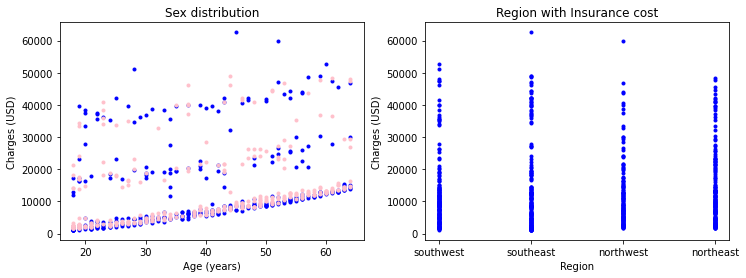

In [453]:
plt.figure(figsize= (12, 4))
plt.subplot(1,2,1)
plt.plot(model_df.age[model_df.sex == 'male'], model_df.charges[model_df.sex == 'male'], 'b.')
plt.plot(model_df.age[model_df.sex == 'female'], model_df.charges[model_df.sex == 'female'], '.', color = 'pink')
plt.title('Sex distribution')
plt.xlabel('Age (years)')
plt.ylabel('Charges (USD)')


plt.subplot(1,2,2)
plt.plot(model_df.region, model_df.charges, 'b.')
plt.title('Region with Insurance cost')
plt.xlabel('Region')
plt.ylabel('Charges (USD)')
plt.show()

As we can see from the above graphs there is not much indication of strong correlations with charges for either of these variables and so have been left out of the model.

One last thing I'd lik to try is to just see how much better the model fits if we take out those outliers identified by the boxplots earlier.

Lets have a look:

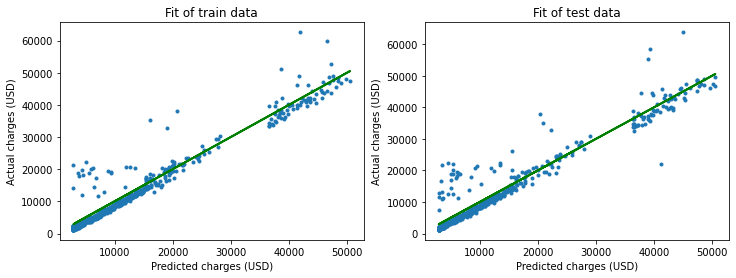

The percentage variation for our train data is 0.9325946390261475
The percentage variation for our test data is 0.9191543207814631


In [454]:
# Create model using equation and coefficients using train data
y_predicted_train = []
model_no_outliers = model_df[((model_df.smoker == 'no') & (model_df.charges < 23000)) | 
                             (model_df.smoker == 'yes')].reset_index()

for i in range(len(model_no_outliers)):
    y_predicted_train.append(age_coef1*model_no_outliers.age[i]**2 + age_coef2*model_no_outliers.age[i] + intercept + 
                             smoker_coef*model_no_outliers.smoker_bin[i] + 
                             bmi_coef*model_no_outliers.smoker_bin[i]*model_no_outliers.bmi_bin[i] + 
                             children_coef*model_no_outliers.children[i])
    
# Adjust the test data as we did for the train data 
test_df['smoker_bin'] = test_df.smoker.apply(lambda x: 1 if x == 'yes' else 0)
test_df['bmi_bin'] = test_df.bmi.apply(lambda x: 1 if x >= 30 else 0)

test_no_outliers = test_df[((test_df.smoker == 'no') & (test_df.charges < 23000)) | (test_df.smoker == 'yes')].reset_index()


# Create model using equation and coefficients using test data
y_predicted_test = []
for i in range(len(test_no_outliers)):
    y_predicted_test.append(age_coef1*test_no_outliers.age[i]**2 + age_coef2*test_no_outliers.age[i] + intercept + 
                            smoker_coef*test_no_outliers.smoker_bin[i] + 
                            bmi_coef*test_no_outliers.smoker_bin[i]*test_no_outliers.bmi_bin[i] + 
                            children_coef*test_no_outliers.children[i])

# Plot our predicted values againsts actual for both train and test data    
plt.figure(figsize = (12, 4))
plt.subplot(1,2,1)
plt.plot(y_predicted_train, model_no_outliers.charges, '.')
plt.plot(y_predicted_train, y_predicted_train, 'g', linewidth = 2)
plt.title('Fit of train data')
plt.xlabel('Predicted charges (USD)')
plt.ylabel('Actual charges (USD)')

plt.subplot(1,2,2)
plt.plot(y_predicted_test, test_no_outliers.charges, '.')
plt.plot(y_predicted_test, y_predicted_test, 'g', linewidth = 2)
plt.title('Fit of test data')
plt.xlabel('Predicted charges (USD)')
plt.ylabel('Actual charges (USD)')

plt.show()

# Calculate percentage variation for train data
R_squared = 1 - (((model_no_outliers.charges - y_predicted_train) ** 2).sum() / 
                 ((model_no_outliers.charges - model_no_outliers.charges.mean()) ** 2).sum())
print('The percentage variation for our train data is ' + str(R_squared))

# Calculate percentage variation for test data
R_squared = 1 - (((test_no_outliers.charges - y_predicted_test) ** 2).sum() / 
                 ((test_no_outliers.charges - test_no_outliers.charges.mean()) ** 2).sum())
print('The percentage variation for our test data is ' + str(R_squared))

Somewhat unsurprisingly the fit improves when we take out the outliers. There are still some datapoints left though that don't fit with the model. If they were also removed it looks look we get pretty close to 0.95. This gives me confidence that there is in fact some other variable missing from our data that would explain these outliers. Which I am pretty sure is pre-existing conditions.

I have also seen other people use the random forest regressor algorithm on this data and gotten a better rating of ~0.88. I could have used this but right now I am not completely sure how that works so I didn't just blindly follow it. Perhaps I'll come back to it some day and see how it fairs. 

I realise my analysis may not be that rigorous and I have only used $R^2$ to evaluate the model but I have ended up with a model that seems to pretty accurately predict someones potential insurance costs as long as they don't have any pre-existing conditions.

If there are any Americans out there reading this, how accurate is my model for you?

Well, the moment of truth, lets see how I fair:

In [455]:
# Create function to calculate cost bassed on my model
def get_charge(age, smoker, bmi, children):
    if bmi >= 30:
        bmi = 1
    else:
        bmi = 0
    charge = age_coef1*age**2 + age_coef2*age + intercept + smoker_coef*smoker + bmi_coef*smoker*bmi + children_coef*children
    return charge

# print out results
print('I would have to pay $' + str(round(get_charge(25, 0, 21, 0))) + ' per year for heath insurance if I lived in the US.')

I would have to pay $3879 per year for heath insurance if I lived in the US.


Wow $3879 is a lot of money, in fact that's about £240 p/m, which is almost half may rent! I can definitely say I am thankful for the NHS here in the UK!

Thanks for taking the time to read all of this! I've learnt quite a lot doing this little project. If anyone wants to discuss this or if someone more experienced has any pointers, let me know, I'd love to chat!